<a href="https://colab.research.google.com/github/Souha-Kabtni/Sales_Predictions/blob/main/Food_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import my to be used packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression  # For model creation (Regression in this case)
from sklearn.tree import DecisionTreeRegressor # For model creation (Decision Tree in this case)
from sklearn.ensemble import RandomForestRegressor # For model creation (random forest Regressor in this case)

from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns', 100)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  # For model evaluation (using Regression metrics)

from sklearn.model_selection import GridSearchCV   # Used for model tuning

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Upload the file
from google.colab import drive
drive.mount('/content/drive')

# Read the fil with pandas
df = pd.read_csv('/content/drive/MyDrive/Coding_Dojo/Stack 2/Core assignments/sales_predictions_2023.csv')

Mounted at /content/drive


# **➿ CRISP-DM Phase 2 - Data Understanding (Data Pre-processing)**

## **Data Cleaning**

In [3]:
# General Look at the data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**How many rows and columns?**

In [4]:
print(f'columns : {df.shape[1]}')
print(f'rows : {df.shape[0]}')

columns : 12
rows : 8523


**✅ There are 8523 rows and 12 columns**

**What are the datatypes of each variable?**

In [5]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

❎ I will drop the 'Item_Identifier' column due to high cardinality, (1559 is a high number of unique labels or classes). High cardinality will create a very sparse dataset when it is One Hot Encoded, which can negatively impact the models' metrics, and greatly increase processing times.

❎ All data types are as they should be.

**Dropping 'Item_Identifier' Column**

In [6]:
# Dropping 'Item_Identifier'

df = df.drop(columns=['Item_Identifier'])
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Checking for duplicated data**


In [7]:
df[df.duplicated()]

# There are no duplicate rows :)

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


**✅ There are no duplicate rows**

### ❌ Finding and Fixing any inconsistent categories of data

In [8]:
# Locate my Object columns
df_types = df.dtypes
# Extract my Object columns only
str_cols = df_types[df_types=="O"]
# find the index of each
str_cols.index
str_cols = str_cols.index

for col in str_cols:
  print(f"{col}:")
  print(df[col].value_counts(dropna=False))
  print("\n\n")

Item_Fat_Content:
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64



Item_Type:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64



Outlet_Identifier:
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64



Outlet_Size:
Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64



Outlet_Location_Type:
Tier 3  

There are 2 columns with missing values that need to be treated:

❎ 'Item_Weight' column's missing values will be imputed with the mean of its values (as recommended by the literature)

❎ 'Outlet_Size' column's missing values will be imputed with the mode of its values (as recommended by the literature)

In [9]:
df.replace({'LF': 'Low Fat', 'low fat': 'Low Fat', 'reg':'Regular'},inplace=True)
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

### ❌ Finding and Fixing any impossible numerical data

In [10]:
df.describe
# There seems to be no impossible values in my numerical column :)

<bound method NDFrame.describe of       Item_Weight Item_Fat_Content  Item_Visibility              Item_Type  \
0           9.300          Low Fat         0.016047                  Dairy   
1           5.920          Regular         0.019278            Soft Drinks   
2          17.500          Low Fat         0.016760                   Meat   
3          19.200          Regular         0.000000  Fruits and Vegetables   
4           8.930          Low Fat         0.000000              Household   
...           ...              ...              ...                    ...   
8518        6.865          Low Fat         0.056783            Snack Foods   
8519        8.380          Regular         0.046982           Baking Goods   
8520       10.600          Low Fat         0.035186     Health and Hygiene   
8521        7.210          Regular         0.145221            Snack Foods   
8522       14.800          Low Fat         0.044878            Soft Drinks   

      Item_MRP Outlet_Identif

In [11]:
df2 = df.copy()   # Making a copy of the data frame at this point since I will be needing it later on for Machine Learning :)

**Missing Values**

In [12]:
(df.isnull().sum()/(len(df)))*100

Item_Weight                  17.165317
Item_Fat_Content              0.000000
Item_Visibility               0.000000
Item_Type                     0.000000
Item_MRP                      0.000000
Outlet_Identifier             0.000000
Outlet_Establishment_Year     0.000000
Outlet_Size                  28.276428
Outlet_Location_Type          0.000000
Outlet_Type                   0.000000
Item_Outlet_Sales             0.000000
dtype: float64

In [13]:
# This is our 1st missing values in the 'Item_Weight' column
df['Item_Weight'].fillna(value =df['Item_Weight'].mean(),inplace=True )
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [14]:
# Now all missing values in 'Item_Weight' column are imputed with the mean of its values
df.isna().sum()

Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [15]:
# Looking for the mode in Outlet_Size's unique values
df['Outlet_Size'].value_counts()

Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [16]:
# For Medium is more reccurent that the other values, NaN will be replaced by it accordingly
df['Outlet_Size'].fillna(value ='Medium',inplace=True )  # or df['Outlet_Size'].fillna(value =df['Outlet_Size'].mode(),inplace=True )
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Medium,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
# Now all missing values in 'Outlet_Size' column are imputed with the most frequent of its values
df.isna().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

**✅ Now our data is free from Missing values**

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   int64  
 7   Outlet_Size                8523 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(6)
memory usage: 732.6+ KB


✅ The dataset is of shape: 8523 row and 12 columns

✅ There are a mixture of datatypes:

6 of type object (having dropped tje Item_Identifier column to its high cardinality)

4 of type float

1 of type integer

## **Exploratory Data Analysis**

# **1. Studying the Distribution of my Target variable column through a Histogram**

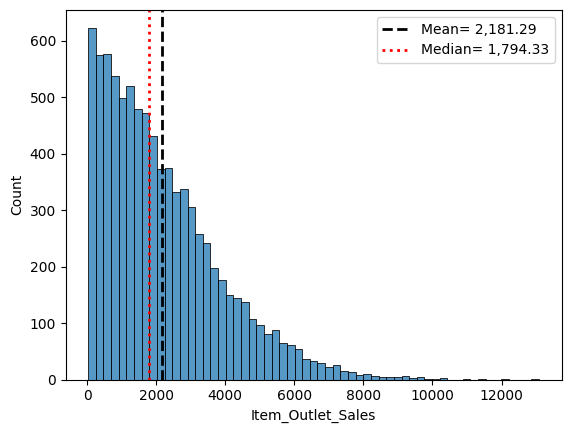

In [19]:
# fig, ax = plt.subplots(figsize = (10,5))
ax = sns.histplot(data = df, x = 'Item_Outlet_Sales')

mean = df['Item_Outlet_Sales'].mean()
ax.axvline(mean,color='k', ls='--', lw=2,
           label= f"Mean= {mean:,.2f}");

median = df['Item_Outlet_Sales'].median()
ax.axvline(median,color='r', ls=':', lw=2,
           label= f"Median= {median:,.2f}");

ax.legend(loc='upper right');

### **This histogram shows that the majority of the Item Outlet Sales are around $2000,000.**

# **2. Studying the Distribution of my Categorical columns through Barplots**

In [20]:
def plot_dist1(data, xcol, ycol, hue, title, figure_size = (20, 10)):

  ## Through plt.subplots(), I am going to set the ground for a larger fig/ax before plotting

 fig, ax = plt.subplots(figsize=figure_size)

## I am going to removing my top and right borders

 ax.spines['right'].set_visible(False)
 ax.spines['top'].set_visible(False)

## I am going to plot a histogram using seaborn library

 sns.barplot(data=data, x = xcol, y = ycol, hue=hue, ax=ax)

## I am going to set my title and my font (family, size, and weight)

 ax.set_title(title, fontfamily='serif', fontsize='xx-large', fontweight='semibold');

## I am going to increase my Axis Label Font Sizes

 ax.set_xlabel(ax.xaxis.get_label().get_text(),
              fontsize='x-large')
 ax.set_ylabel(ax.yaxis.get_label().get_text(),
              fontsize='x-large')

 plt.xticks(rotation = 45)

 ## ax.xaxis.label()
 ax.legend(loc='upper right');

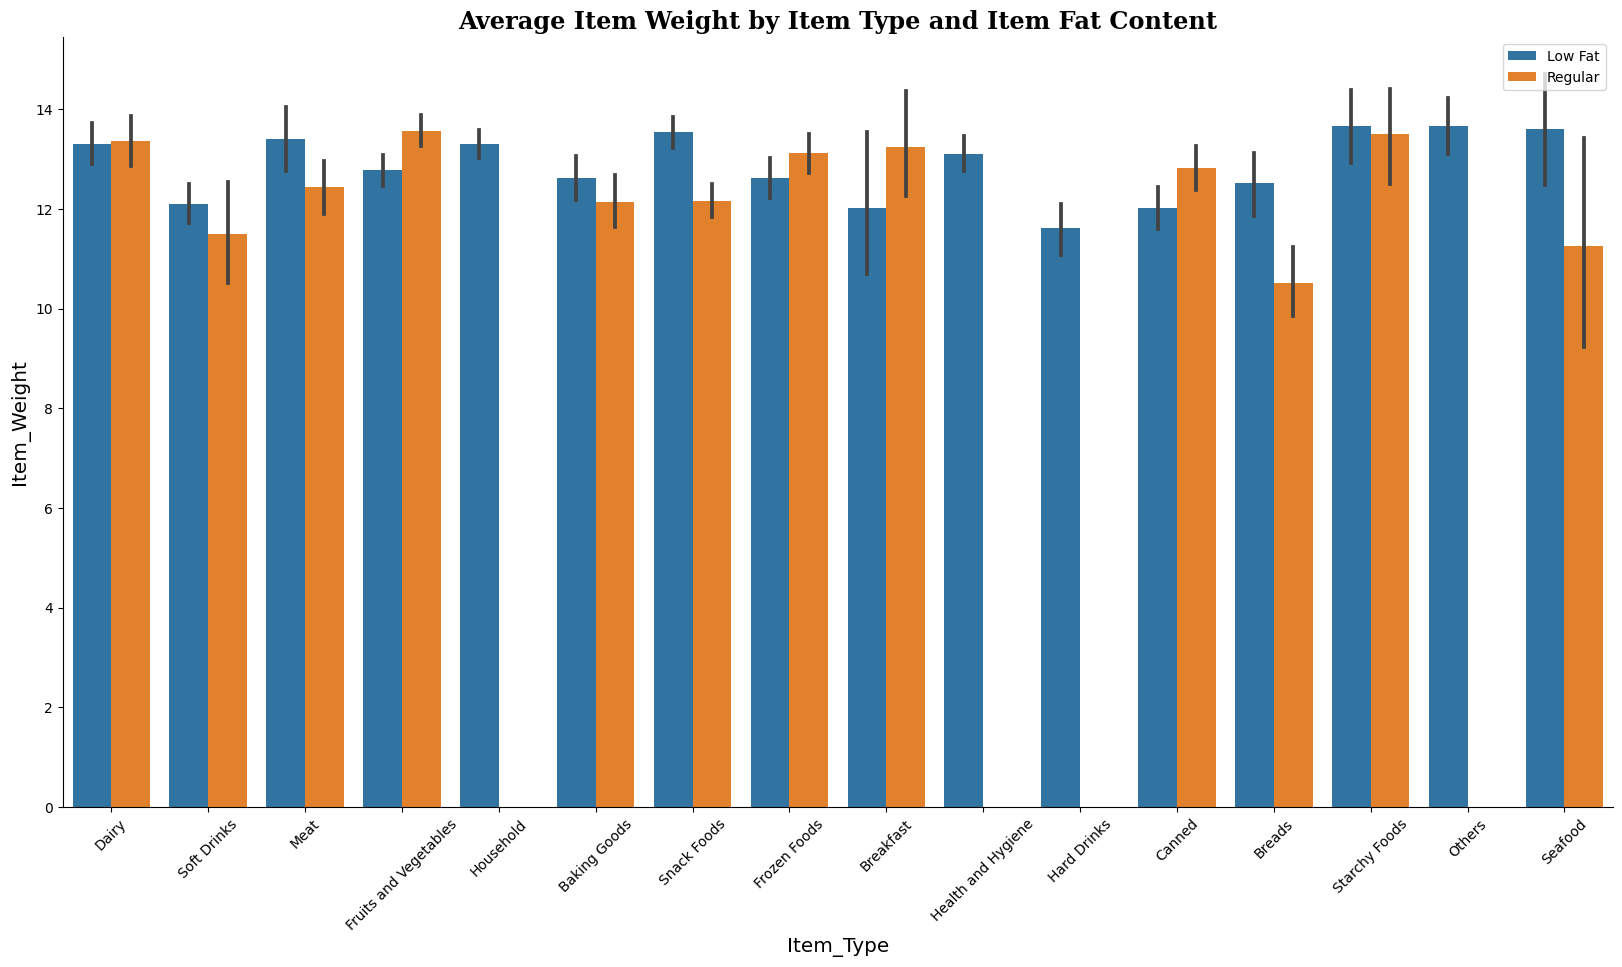

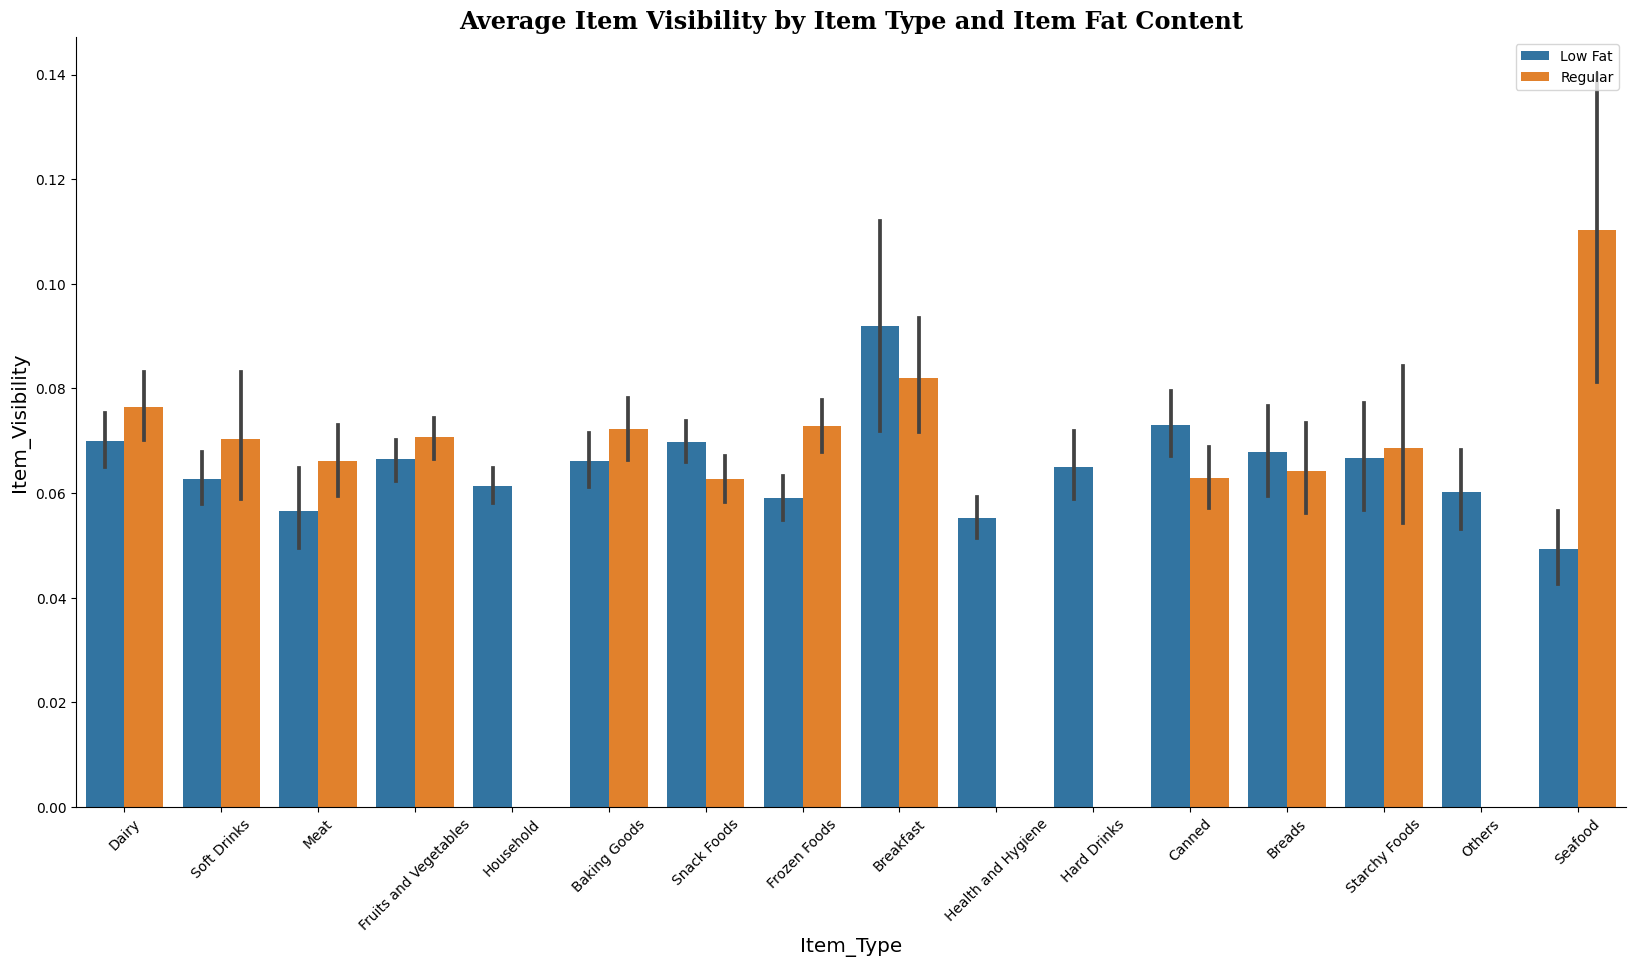

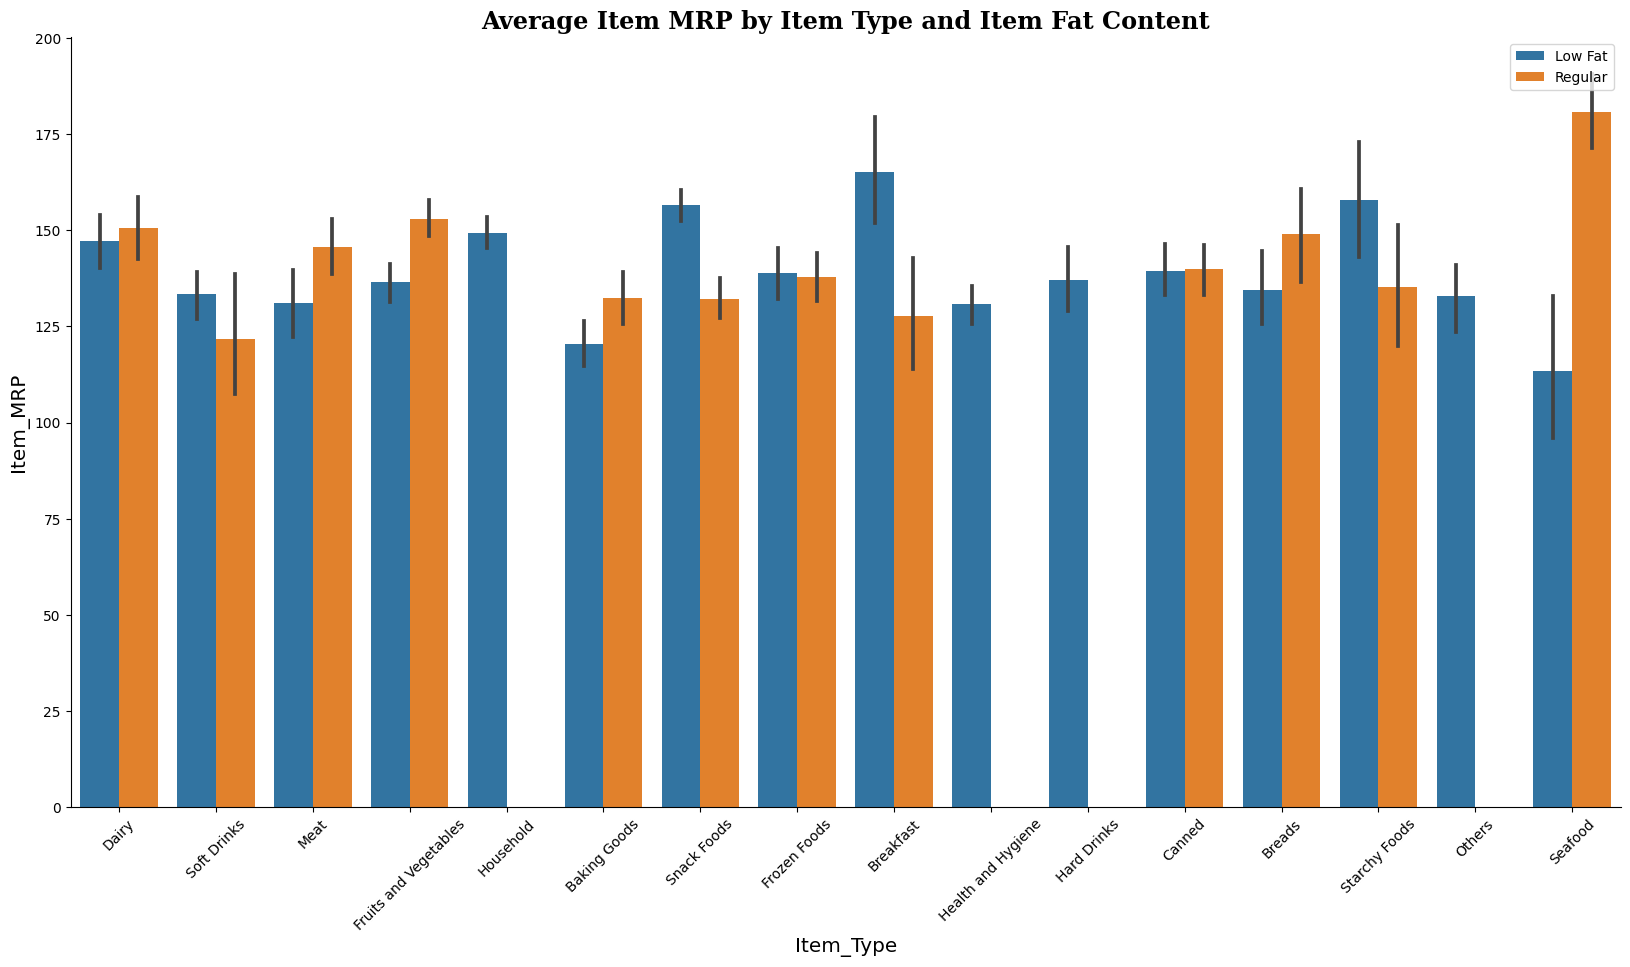

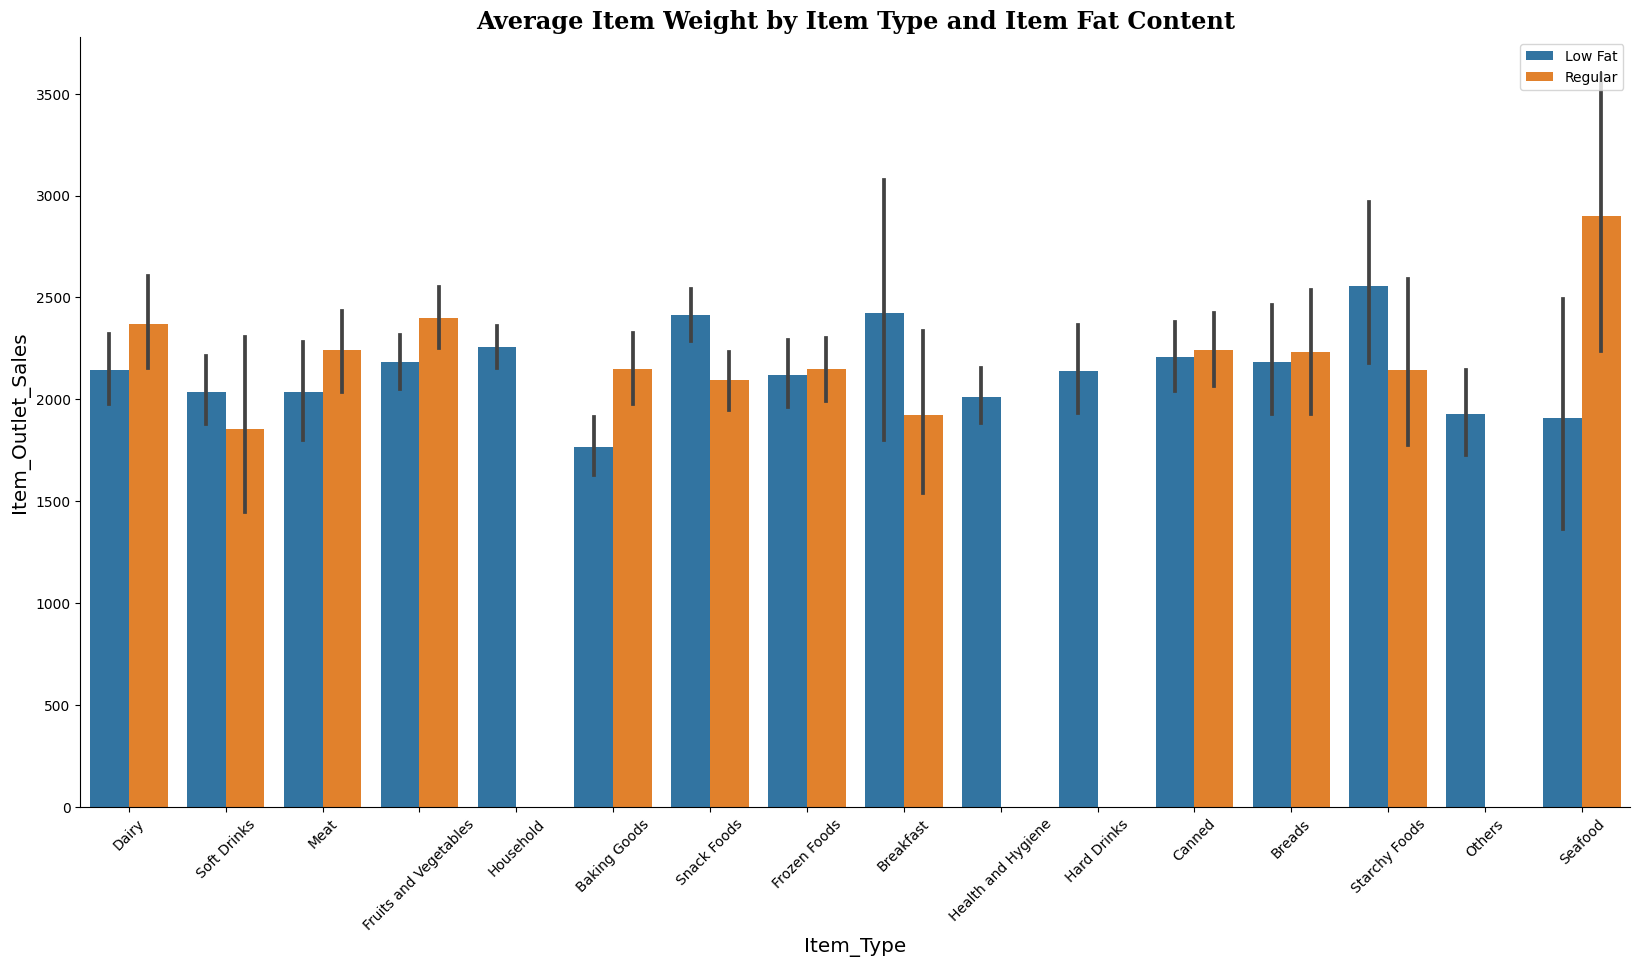

In [21]:
# Graph some examples of barplots that can come from the above created function:

plot_dist1(df, df.Item_Type, df.Item_Weight, df.Item_Fat_Content, 'Average Item Weight by Item Type and Item Fat Content')
plot_dist1(df, df.Item_Type, df.Item_Visibility, df.Item_Fat_Content, 'Average Item Visibility by Item Type and Item Fat Content')
plot_dist1(df, df.Item_Type, df.Item_MRP, df.Item_Fat_Content, 'Average Item MRP by Item Type and Item Fat Content')
plot_dist1(df, df.Item_Type, df.Item_Outlet_Sales, df.Item_Fat_Content, 'Average Item Weight by Item Type and Item Fat Content')

# **✅ Interpretation of the barplots:**

## **↪ 1st Graph:** Item weight over item type by item fat content barplot shows that although almost all items are both low in fat and regular, Hard Drinks are only low in fat.

## **↪ 2nd Graph:** Item visibility over item type by item fat content demonstrates that Seafood with regular fat is the most visible item while Breakfast has the highest visibility in terms of low fat.

## **↪ 3rd Graph:** Item MRP over item type by item fat content shows that Seafood with regular fat has the highest MRP while its low fat has the lowest MRP.

## **↪ 4th Graph:** Item outlet sales over item type by item fat content further accentuate the previous interpretation of the 3rd graph with Seafood having the highest and lowest outlet sales, regular and fat, respectively.

# **3. Studying the Distribution of my Numerical columns through Histograms**

In [22]:
# Since I have 5 Numerical columns, and to avoid repetition of codes, I will create a function for a histogram and call it plot_dist

def plot_dist(data, col, title, figure_size = (10,5)):  # def plot_dist(data, col, title, figure_size = (10,5), font_family = 'serif', font_weight = 'semibold') => Why they did not work?

## Through plt.subplots(), I am going to set the ground for a larger fig/ax before plotting

 fig, ax = plt.subplots(figsize=figure_size)

## I am going to removing my top and right borders

 ax.spines['right'].set_visible(False)
 ax.spines['top'].set_visible(False)

## I am going to plot a histogram using seaborn library

 sns.histplot(data=data, x=col, ax=ax, kde=True, line_kws={'color': 'pastel', 'lw': 5, 'ls': ':'})

## I am going to set my title and my font (family, size, and weight)

 ax.set_title(title, fontfamily='serif', fontsize='xx-large', fontweight='semibold');

## I am going to increase my Axis Label Font Sizes

 ax.set_xlabel(ax.xaxis.get_label().get_text(),
              fontsize='x-large')
 ax.set_ylabel(ax.yaxis.get_label().get_text(),
              fontsize='x-large')

## Annotating mean

 mean = data[col].mean()
 ax.axvline(mean,color='k', ls='solid', lw=3,
           label= f"Mean= {mean:,.2f}");

## Annotating median

 median = data[col].median()
 ax.axvline(median,color='r', ls=':', lw=3,
           label= f"Median= {median:,.2f}");


## ax.xaxis.label()
 ax.legend(loc='upper right');


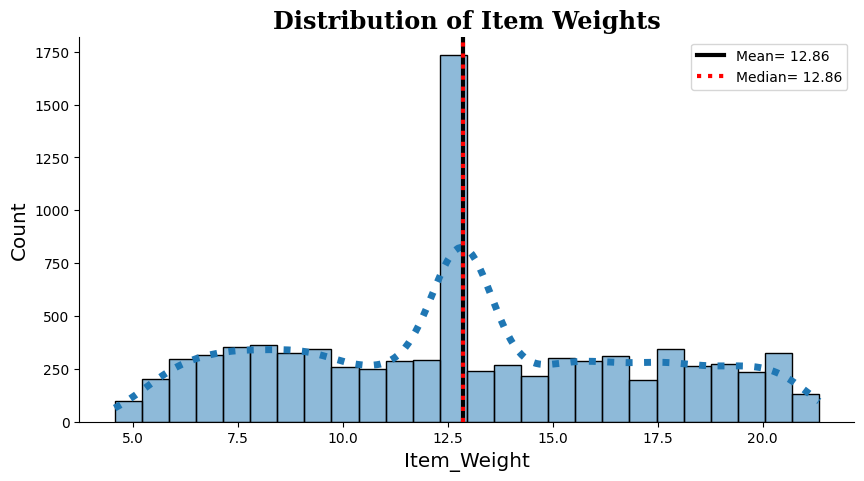

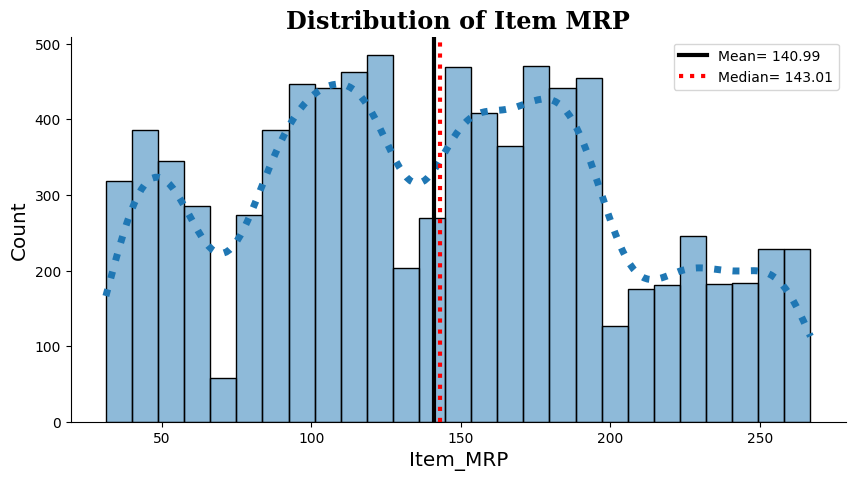

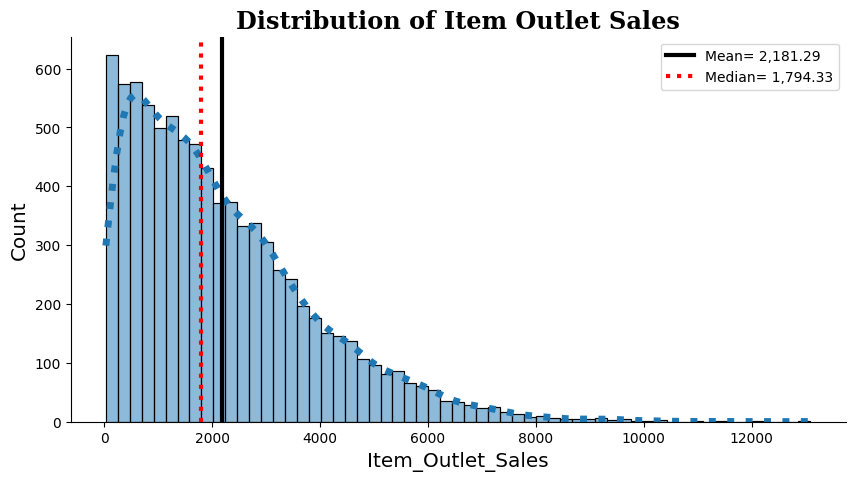

In [23]:
# Graph some examples of histograms that can come from the above created function:

plot_dist(df, 'Item_Weight', 'Distribution of Item Weights');
plot_dist(df, 'Item_MRP', 'Distribution of Item MRP');
plot_dist(df, 'Item_Outlet_Sales', 'Distribution of Item Outlet Sales');

# **✅ Interpretation of the Histograms:**

## **↪ 1st Graph:** Item weights has a normal distribution where both the mean and the median match. The 1 peak in the histogram shows that the data set is with one mode, unimodal, with a weitgh of 12 as the most frequent.

## **↪ 2nd Graph:** Item MRP has a normal distribution where both the mean and the median approximatly match. With multiple peaks to represent a data set with multiple modes, multimodal, MRPs between the intervals 100-130 and 150-200 are the most frequent.

## **↪ 3rd Graph:** The Distribution of Item Outlet Sales histograms is right/positively skewed which entails that many of the values are near the lower end of the range, and higher values are infrequent. In this case, the moset frequent distribution of Item Outlet Sales is centered between $0 to $2,000.

**4. Correlation - Chart Type: Heatmap**

In [24]:
# I am searching for the correlation between all numercial values in my df dataframe

correlation = df.corr()
correlation

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.000000,-0.012049,0.024756,-0.008301,0.011550
Item_Visibility,-0.012049,1.000000,-0.001315,-0.074834,-0.128625
Item_MRP,0.024756,-0.001315,1.000000,0.005020,0.567574
Outlet_Establishment_Year,-0.008301,-0.074834,0.005020,1.000000,-0.049135
Item_Outlet_Sales,0.011550,-0.128625,0.567574,-0.049135,1.000000


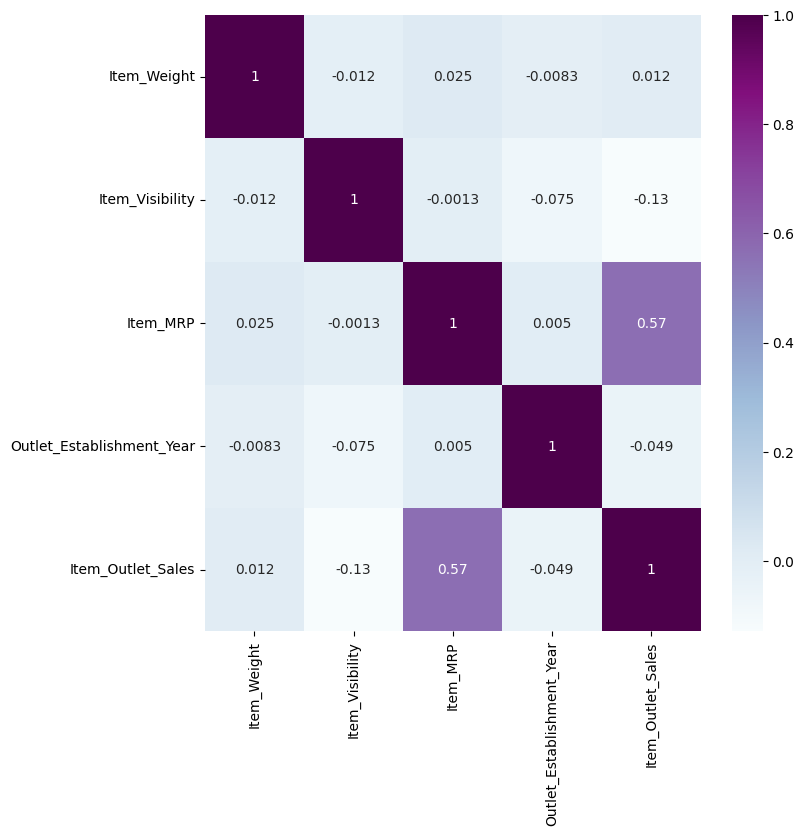

In [25]:
plt.figure(figsize=(8,8))
sns.heatmap(df.corr(),cmap='BuPu', annot=True);

# **✅ Interpretation of the Heatmap:**

## **↪ With a positive correlation of 0.57, Item_MRP and Item_Outlet_Sales moderately correlate.**
## **↪ With a negative correlation of -0.13 and -0.049 between Item_Visibility and Outlet_Establishment_Year respectively with Item_Outlet_Sales.**

## ** ✌ Conclusion: The more the product is high in price, the more it is sold.**

# **➿ CRISP-DM Phase 3 - Data Preparation (Data Munging)**

**Defining X and y for the Train-Test-Split**

In [26]:
y = df['Item_Outlet_Sales']
X = df.drop(columns='Item_Outlet_Sales')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Making a Preprocessing Pipeline**

In [27]:
# For Numerical Feartures

# Defining a list of features
numerical_cols = X_train.select_dtypes("number").drop(columns='Outlet_Establishment_Year').columns
ordinal_cols = ['Outlet_Size']
nominal_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Location_Type', 'Outlet_Type']


# Instantiating the Transformers
impute_mean = SimpleImputer()
impute_most_frequent = SimpleImputer(strategy='most_frequent')
Outlet_Size_order = ['Small', 'Medium', 'High']
ordinal_encoder = OrdinalEncoder(categories=[Outlet_Size_order])
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()


# Instantiating the pipeline
numerical_pipe = make_pipeline(impute_mean, scaler)
ordinal_pipe = make_pipeline(impute_most_frequent, ordinal_encoder, scaler)
nominal_pipe = make_pipeline(ohe_encoder)


# Defining a tuple for each pathway
numerical_tup = ('Numerical', numerical_pipe, numerical_cols)
ordinal_tup = ('Ordinal', ordinal_pipe, ordinal_cols)
nominal_tup = ('Nominal', nominal_pipe, nominal_cols)


# Instantiating the ColumnTransformer
col_transformer = ColumnTransformer([numerical_tup, ordinal_tup, nominal_tup], remainder='passthrough', verbose_feature_names_out=False)
col_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('Numerical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                ('Ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('Nominal',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Item_Fat_Content', 'Item_Type',
                                  'Outlet_Identifier', 'Outlet_Location_Type',
                                  'Outlet_Type'])],
                  verbose_feature_names_out=False)

# **➿ CRISP-DM Phase 4 - Modeling**

## **1st model - Linear Regression model to predict sales**

In [28]:
# define a function that takes true and predicted values as arguments for later evaluation of each model using 2 evaluation metrics (RMSE and R²)

def eval_model(true, pred):
  RMSE = mean_squared_error(true, pred, squared = False)
  r2 = r2_score(true, pred)

  print(f'R2: {r2:,.3f} \n RMSE: {RMSE:,.3f}')

In [29]:
# Instantiate a linear regression model
linreg = LinearRegression()
# Combine the preprocessing ColumnTransformer and the linear regression model in a Pipeline
model_pipeR = make_pipeline(col_transformer, linreg)

# Fit the modeling pipeline on the training data
model_pipeR.fit(X_train, y_train)

# Use the model to make predictions for training and testing data
y_pred_trainL = model_pipeR.predict(X_train) # Get predictions for the training data ==> WHY? he already learned from it, his predictions are to be 100% correct, right?

y_pred_testL = model_pipeR.predict(X_test) # Get predictions for the testing data

In [30]:
# RMSE and R² scores of the Linear Regression Model

print('Train Evaluation''\n')
eval_model(y_train, y_pred_trainL)
print('\n')

print('Test Evaluation''\n')
eval_model(y_test, y_pred_testL)

Train Evaluation

R2: 0.561 
 RMSE: 1,139.267


Test Evaluation

R2: 0.567 
 RMSE: 1,092.592


## **2nd model - Regression Tree model to predict sales**

In [31]:
# Instantiate a Regression Tree model
dec_tree = DecisionTreeRegressor(random_state = 42)

# Combine the preprocessing ColumnTransformer and the linear regression model in a Pipeline
model_pipeD = make_pipeline(col_transformer, dec_tree)

# Fit the modeling pipeline on the training data

model_pipeD.fit(X_train, y_train)

# Use the model to make predictions for training and testing data

y_pred_trainT = model_pipeD.predict(X_train) # Get predictions for the training data ==> WHY? he already learned from it, his predictions are to be 100% correct, right?

y_pred_testT = model_pipeD.predict(X_test) # Get predictions for the testing data

In [32]:
# RMSE and R² scores of the Regression Tree Model

print('Train Evaluation''\n')
eval_model(y_train, y_pred_trainT)
print('\n')

print('Test Evaluation''\n')
eval_model(y_test, y_pred_testT)

Train Evaluation

R2: 1.000 
 RMSE: 0.000


Test Evaluation

R2: 0.183 
 RMSE: 1,501.458


## **Untuned Decision Tree Model Observations**

+ This model performs extremely well on the training data. However, it performs poorly on the testing set with an R& value of 0.183.
+ This is an instance of overfitting that needs to be addressed by tuning its hyperparameters using GridsearchCV.

In [33]:
print(f'- What was the depth of my default tree? {dec_tree.get_depth()}')   # This is to get the max_depth of the default model. This value will be used later on while tuning the model
print(f'- What was the min samples split of my default tree? {dec_tree.min_samples_split}')
print(f'- What was the min samples leaf of my default tree? {dec_tree.min_samples_leaf}')

- What was the depth of my default tree? 40
- What was the min samples split of my default tree? 2
- What was the min samples leaf of my default tree? 1


In [34]:
dec_tree = DecisionTreeRegressor(random_state = 42)   # This is the model I am to tune
DC = make_pipeline(col_transformer, dec_tree)
DC.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('Numerical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP'], dtype='object')),
                                   ('Ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('ordinalencoder',
                                                     OrdinalEncoder(categories=[['Small',
                                                                                 'Medium

In [35]:
param_grid = {'decisiontreeregressor__max_depth': np.arange(1,40),
              'decisiontreeregressor__min_samples_split': [5, 10, 15],
              'decisiontreeregressor__min_samples_leaf' : [2, 4, 6]}
knn_pipe_gs = GridSearchCV(DC, param_grid)
knn_pipe_gs.fit(X_train, y_train)
knn_pipe_gs.best_params_

{'decisiontreeregressor__max_depth': 5,
 'decisiontreeregressor__min_samples_leaf': 6,
 'decisiontreeregressor__min_samples_split': 15}

## **Re-evaluating Decision Tree Regressor Model (having found the best hyperparameter-values for max_depth, min_smaples-split, and min_samples_leaf)**

In [36]:
# Instantiate a Regression Tree model
dec_tree_T = DecisionTreeRegressor(random_state = 42, max_depth = 5, min_samples_split = 6, min_samples_leaf = 15)

# Combine the preprocessing ColumnTransformer and the linear regression model in a Pipeline
model_pipeD5 = make_pipeline(col_transformer, dec_tree_T)

# Fit the modeling pipeline on the training data

model_pipeD5.fit(X_train, y_train)

# Use the model to make predictions for training and testing data

y_pred_trainT5 = model_pipeD5.predict(X_train) # Get predictions for the training data ==> WHY? he already learned from it, his predictions are to be 100% correct, right?

y_pred_testT5 = model_pipeD5.predict(X_test) # Get predictions for the testing data

In [37]:
# RMSE and R² scores of the Regression Tree Model

print('Train Evaluation''\n')
eval_model(y_train, y_pred_trainT5)
print('\n')

print('Test Evaluation''\n')
eval_model(y_test, y_pred_testT5)

Train Evaluation

R2: 0.604 
 RMSE: 1,082.922


Test Evaluation

R2: 0.596 
 RMSE: 1,055.975


# **➿ CRISP-DM Phase 5 - Evaluation**

## **Tuned (Max Depth) Decision Tree Model**
+ Tuning the max depth, min_samples_split and min_samples_leaf on the decision tree model improved the results for the testing data (with higher R² and lower RMSE values). Now the model performs poorly on the training set (0.604, unlike the untuned model with an R value of 1).
+ The model still has high bias even after tuning the max depth, yet it delivers slightly better results than Linear Regression (at the level of R² and RMSE).